<a href="https://colab.research.google.com/github/zacharylazzara/tent-detection/blob/main/mask_r_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Referenced Materials**

* https://amaarora.github.io/2020/09/13/unet.html
* https://towardsdatascience.com/unet-line-by-line-explanation-9b191c76baf5
* https://towardsdatascience.com/understanding-semantic-segmentation-with-unet-6be4f42d4b47
* https://www.youtube.com/watch?v=IHq1t7NxS8k

The majority of this comes from the referenced YouTube video

# Imports and Initialization

In [1]:
# Imports
!pip install segmentation-models-pytorch -q
!pip install -U albumentations -q

!pip uninstall keras -y -q
!pip uninstall keras-Preprocessing -y -q
!pip uninstall keras-vis -y -q
!pip uninstall tensorflow -y -q
!pip uninstall h5py -y -q

!pip install tensorflow==1.13.1 -q
!pip install keras==2.0.8 -q
!pip install h5py==2.10.0 -q

import sys
import os
import csv
import random
import torch
import torchvision
import torch.utils.data
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import segmentation_models_pytorch as smp
import torch.optim as optim
import torch.nn as nn
import torchvision.transforms.functional as TF
import numpy as np
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from mpl_toolkits.axes_grid1 import ImageGrid
import cv2
from google.colab.patches import cv2_imshow
from pathlib import Path
from glob import glob

     |████████████████████████████████| 87 kB 2.2 MB/s 
     |████████████████████████████████| 58 kB 4.1 MB/s 
     |████████████████████████████████| 376 kB 19.8 MB/s 
     |████████████████████████████████| 102 kB 5.3 MB/s 
     |████████████████████████████████| 47.6 MB 35 kB/s 
     |████████████████████████████████| 92.6 MB 1.2 MB/s 
     |████████████████████████████████| 3.2 MB 41.0 MB/s 
     |████████████████████████████████| 42 kB 1.2 MB/s 
     |████████████████████████████████| 50 kB 4.8 MB/s 
     |████████████████████████████████| 367 kB 36.0 MB/s 
     |████████████████████████████████| 4.1 MB 36.1 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kapre 0.3.5 requires tensorflow>=2.0.0, but you have tensorflow 1.13.1 which is incompatible.
     |████████████████████████████████| 276 kB 5.1 MB/s 
     |████████████████████████████████| 2.9 MB

In [2]:
# Initialize Environment
%env SRC_DIR        = sarpol-zahab-tents/
%env MRCNN_DIR      = Mask_RCNN/
%env DATA_DIR       = data/
%env TRAINING_DIR   = data/training/
%env VALIDATION_DIR = data/validation/
%env TRAIN_IMG_DIR  = data/training/images/
%env TRAIN_LBL_DIR  = data/training/masks/
%env VAL_IMG_DIR    = data/validation/images/
%env VAL_LBL_DIR    = data/validation/masks/
%env PREDICT_DIR    = predictions/

%env IMAGE_DIR    = images/
%env MASK_DIR     = masks/

SRC_DIR         = os.environ.get("SRC_DIR")
MRCNN_DIR       = os.environ.get("MRCNN_DIR")
DATA_DIR        = os.environ.get("DATA_DIR")
TRAINING_DIR    = os.environ.get("TRAINING_DIR")
VALIDATION_DIR  = os.environ.get("VALIDATION_DIR")
TRAIN_IMG_DIR   = os.environ.get("TRAIN_IMG_DIR")
TRAIN_LBL_DIR   = os.environ.get("TRAIN_LBL_DIR")
VAL_IMG_DIR     = os.environ.get("VAL_IMG_DIR")
VAL_LBL_DIR     = os.environ.get("VAL_LBL_DIR")
PREDICT_DIR     = os.environ.get("PREDICT_DIR")


IMAGE_DIR = os.environ.get("IMAGE_DIR")
MASK_DIR = os.environ.get("MASK_DIR")

env: SRC_DIR=sarpol-zahab-tents/
env: MRCNN_DIR=Mask_RCNN/
env: DATA_DIR=data/
env: TRAINING_DIR=data/training/
env: VALIDATION_DIR=data/validation/
env: TRAIN_IMG_DIR=data/training/images/
env: TRAIN_LBL_DIR=data/training/masks/
env: VAL_IMG_DIR=data/validation/images/
env: VAL_LBL_DIR=data/validation/masks/
env: PREDICT_DIR=predictions/
env: IMAGE_DIR=images/
env: MASK_DIR=masks/


In [3]:
# Initialize Directories
%%bash
echo "Working in Directory: $(pwd)"

if [ -d 'sample_data' ]; then
  rm -r sample_data
fi

if [ ! -d $SRC_DIR ]; then
 git clone https://github.com/tofighi/sarpol-zahab-tents.git
fi

# if [ ! -d $DATA_DIR ]; then
#   mkdir -p $DATA_DIR
#   mv $SRC_DIR/data/sarpol_counts.csv $DATA_DIR
# fi

if [ ! -d $MRCNN_DIR ]; then
 git clone https://github.com/matterport/Mask_RCNN.git
 mv $MRCNN_DIR/mrcnn $MRCNN_DIR/..
fi

if [ ! -d $TRAINING_DIR ]; then
  mkdir -p $TRAINING_DIR
fi

if [ ! -d $VALIDATION_DIR ]; then
  mkdir -p $VALIDATION_DIR
fi

if [ ! -d $TRAIN_IMG_DIR ]; then
  mkdir -p $TRAIN_IMG_DIR
fi

if [ ! -d $TRAIN_LBL_DIR ]; then
  mkdir -p $TRAIN_LBL_DIR
fi

if [ ! -d $VAL_IMG_DIR ]; then
  mkdir -p $VAL_IMG_DIR
fi

if [ ! -d $VAL_LBL_DIR ]; then
  mkdir -p $VAL_LBL_DIR
fi

if [ ! -d $PREDICT_DIR ]; then
  mkdir -p $PREDICT_DIR
fi

Working in Directory: /content


Cloning into 'sarpol-zahab-tents'...
Cloning into 'Mask_RCNN'...


# Configuration

In [4]:
# Configuration
IMAGE_HEIGHT  = 512
IMAGE_WIDTH   = 512

# Dataset
TEST_SIZE         = 0.3
RANDOM_STATE      = 123
ALLOW_IRRELEVANT  = False # If images don't have tents do we want to throw them out or not?
SARPOL            = False # do we want to download the very large Sarpol image?
TENT_CSV          = f"{DATA_DIR}tent_counts.csv"
MAX_TENT_COUNT    = 50#IMAGE_HEIGHT * IMAGE_WIDTH // 1000 # Ideally heigth x width is the maximum tent count, but it's best to define it smaller for the sake of performance; integer division by tent size would also be acceptable
CUTOFF_SCORE      = 0.75 # The higher this is the longer kmeans will run; set to 1 if we want the best possible score at expense of time

# Display Limit
DISP_LIMIT    = 1 # Maximum number of images to display
DISP_RESULTS  = True
DISP_SCALE    = 2#150 # Amount to integer divide displayed figure scale by (set to 1 to disable); useful if the notebook keeps crashing

# Images
IMG_FORMAT    = "jpg"

# Checkpoints
CHECKPOINT    = "checkpoint.pt"

# Hyperparameters
LEARNING_RATE = 1e-4 # 1x10^-4 = 0.0001
DEVICE        = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE    = 1#5 # Batch size defines the prediction batch; set to 1 if we want individual files
NUM_EPOCHS    = 50 #100
NUM_WORKERS   = 2

PIN_MEMORY    = True
LOAD_MODEL    = False

# Convolution Settings
C_KERNEL      = 3     # This is the matrix that slides across the image (we define matrix size, so kernel = 3 means 3x3 matrix that slides across the image)
C_STRIDE      = 1     # Number of pixels the kernel slides over the input (how many pixels we move the filter at a time)
C_PADDING     = 1     # Sometimes the filter doesn't perfectly fit the input image, in which case we can pad with 0s or drop the part of the image that didn't fit (called valid padding)
C_BIAS        = False # Bias is false in this case because we're using BatchNorm2d (bias would be canceled by the batch norm, so we set it to false)
R_INPLACE     = True  #

# UNet Settings
IN_CHANNELS   = 3
OUT_CHANNELS  = 1 # We're doing binary image segmentation (because our masks are black and white), so we can output a single channel
U_FEATURES    = [64, 128, 256, 512] # Features come from the architecture (the number above the boxes)

# UNet Pool Settings
P_KERNEL      = 2
P_STRIDE      = 2

# Final layer kernel size
F_KERNEL      = 1 # Because we're outputting the final image here



# Accuracy; this is used to prevent division by zero, so we want a small value that doesn't have much impact on the results
EPSILON = sys.float_info.epsilon

In [5]:
def load(path):
  return np.array([np.asarray(Image.open(path)) for path in sorted(glob(path))])
  
MAP = None
if SARPOL:
  !gdown --id 1-YUbFjwFL2G5r8TudKS0XK56BjJ0KsTK
  MAP = load("sarpol.png")[0]
  print(f"Sarpol Shape: {MAP.shape}\n")

if LOAD_MODEL:
  !gdown --id 1ulHrgSyNwo1X2WYmQyeb4lIxIIJ4Xs-G

# Preprocessing

In [6]:
# Preparing Data
tent_counts = []
with open(f"{SRC_DIR}data/sarpol_counts.csv") as csvfile:
  for row in csv.reader(csvfile):
    tent_counts.append([int(row[1])])

with open(TENT_CSV, 'w') as csvfile:
  csv.writer(csvfile).writerows(tent_counts)

src_imgs = load(f"{SRC_DIR}data/images/*")
src_lbls = load(f"{SRC_DIR}data/labels/*")

dataset = []
# Dataset Structure:
# [
#   0:{
#     img:  image
#     lbl:  label
#     filename: {img: 0.png, lbl: 0.png}
#   },
#   1:{}, 2:{}, n:{}
# ]

if src_imgs.shape[0] == src_lbls.shape[0]:
  n = src_lbls.shape[0]

  for index in range(n):
    dataset.append({
      "img":Image.fromarray(src_imgs[index]),
      "lbl":Image.fromarray(src_lbls[index]),
      "filename":{
        "img":f"{index}.{IMG_FORMAT}",
        "lbl":f"{index}.{IMG_FORMAT}"
      }
    })

def save_data(data, val=False):
  img_dir = TRAIN_IMG_DIR
  lbl_dir = TRAIN_LBL_DIR

  if val:
    img_dir = VAL_IMG_DIR
    lbl_dir = VAL_LBL_DIR

  data["img"].save(f"{img_dir}/{data['filename']['img']}")
  data["lbl"].save(f"{lbl_dir}/{data['filename']['lbl']}")

relevant = 0
irrelevant = 0
for data in dataset:
  if np.asarray(data["lbl"]).sum() > 0:
    relevant += 1
  else:
    irrelevant += 1

def percent(sample, total):
  return f"({sample}/{total}) = {((sample/total)*100):.2f}%"

total = len(dataset)
print(f"Dataset Size: {total}\nRelevant Percentage: {percent(relevant, total)}, Irrelevant Percentage: {percent(irrelevant, total)}")
print(f"Allow Irrelevant Data? {'YES' if ALLOW_IRRELEVANT else 'NO'}")

training_set, validation_set = train_test_split(dataset, test_size=TEST_SIZE, random_state=RANDOM_STATE)

training_data = 0
for training in training_set:
  if ALLOW_IRRELEVANT or np.asarray(training["lbl"]).sum() > 0:
    save_data(training, val=False)
    training_data += 1
    
validation_data = 0
for testing in validation_set:
  if ALLOW_IRRELEVANT or np.asarray(testing["lbl"]).sum() > 0:
    save_data(testing, val=True)
    validation_data += 1


total_usable = training_data + validation_data
print(f"\nTraining Percentage: {percent(training_data, total_usable)}, Validation Percent: {percent(validation_data, total_usable)}")



# TODO: need to generate augmented data too (or at least ensure augmented data expands the dataset and doesn't just replace it), and also re-train the model on the updated version

Dataset Size: 256
Relevant Percentage: (90/256) = 35.16%, Irrelevant Percentage: (166/256) = 64.84%
Allow Irrelevant Data? NO

Training Percentage: (64/90) = 71.11%, Validation Percent: (26/90) = 28.89%


In [7]:
# Cleanup
%%bash
if [ -d $SRC_DIR ]; then
  rm -r $SRC_DIR
fi

# Dataset

In [8]:
# TentDataset
# Adapted From https://www.youtube.com/watch?v=IHq1t7NxS8k

# Data directory should be in the format:
# data
#   train_images
#   train_masks
#   val_images
#   val_masks

class TentDataset(Dataset):
  def __init__(self, image_dir=TRAIN_IMG_DIR, mask_dir=TRAIN_LBL_DIR, transform=None):
    self.image_dir = image_dir
    self.mask_dir = mask_dir
    self.transform = transform
    self.images = os.listdir(image_dir)

  def __len__(self):
    return len(self.images)

  def __getitem__(self, index):
    image_path = os.path.join(self.image_dir, self.images[index])
    mask_path = os.path.join(self.mask_dir, self.images[index])
    image = np.array(Image.open(image_path).convert("RGB"))
    mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32) # We use L since mask is grey scale
    mask[mask == 255.0] = 1.0 # Preprocessing; we change this cuz we're using a sigmoid on the last activation for probability of white pixel, so this makes it work better?

    if self.transform is not None:
      augmentations = self.transform(image=image, mask=mask)
      image = augmentations["image"]
      mask = augmentations["mask"]

    return image, mask

# Mask R-CNN

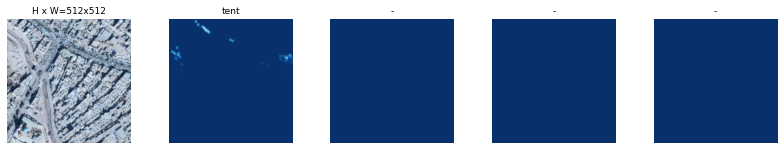

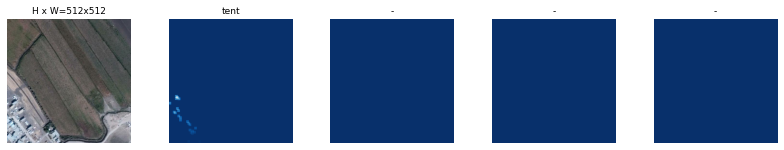

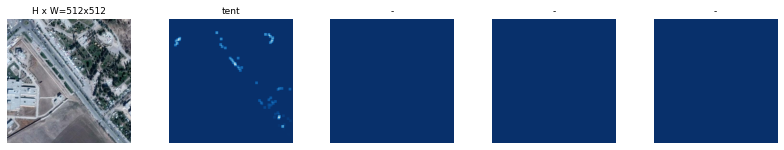

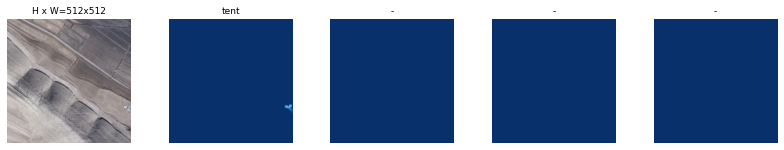


Starting at epoch 0. LR=0.0001

Checkpoint Path: /logs/tents20211113T2306/mask_rcnn_tents_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b          (BatchNor

/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


KeyError: ignored

In [69]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import skimage.io
import cv2
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)



# Configurations
class TentsConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "tents"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    # Number of classes (including background)
    NUM_CLASSES = 2  # background + 1 tent

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = TentsConfig()
# config.display()



# Notebook Preferences
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax



from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
#from scipy.spatial.distance import pdist

#from sklearn.metrics import pairwise_distances_argmin


# # Taken from the clusters example by Ghassem Tofighi
# def find_clusters(X, n_clusters, rseed=2):
#   # 1. Randomly choose clusters
#   rng = np.random.RandomState(rseed)
#   i = rng.permutation(X.shape[0])[:n_clusters]
#   centers = X[i]

#   while True:
#     # 2a. Assign labels based on closest center
#     labels = pairwise_distances_argmin(X, centers)
        
#     # 2b. Find new centers from means of points
#     new_centers = np.array([X[labels == i].mean(0) for i in range(n_clusters)])
        
#     # 2c. Check for convergence
#     if np.all(centers == new_centers):
#       break
#     centers = new_centers
    
#   return centers, labels






class TentsDataset(utils.Dataset):
  def tent_kmeans(self, X, mtc = MAX_TENT_COUNT):
    best = (0, 0, (0,0)) # (k, score, xy)
    k_range = tqdm(range(2, mtc + 2))
    for k in k_range:
      kmeans = KMeans(n_clusters=k)
      kmeans.fit(X)
      y_kmeans = kmeans.predict(X)
      centers = kmeans.cluster_centers_
      xy = (centers[:,0], centers[:,1])

      s_score = silhouette_score(X, kmeans.labels_, metric='euclidean')
      best = (k, s_score, xy) if s_score > best[1] else best

      k_range.set_description(f"K: {k}, Silhouette Score: {s_score:.2f}, Cutoff Score: {CUTOFF_SCORE:.2f} | Best: (k={best[0]}, s={best[1]:.2f}) | Progress")
      if s_score >= CUTOFF_SCORE:
        break
    return best[2]





  def load_tents(self, count, height, width, path):
    self.add_class("tents", 1, "tent")

    img_dir = f"{path}{IMAGE_DIR}"
    msk_dir = f"{path}{MASK_DIR}"
    
    img_names = os.listdir(img_dir)
    msk_names = os.listdir(msk_dir)

    for i in range(count):
      image_name = random.choice(img_names)
      mask = cv2.imread(f"{path}{MASK_DIR}{image_name}", cv2.IMREAD_GRAYSCALE)
      
      params = cv2.SimpleBlobDetector_Params()
      params.minArea = 1;
      params.maxArea = IMAGE_HEIGHT * IMAGE_WIDTH;
      params.minDistBetweenBlobs = 0
      params.filterByColor = True
      params.filterByArea = True
      params.filterByCircularity = False
      params.filterByInertia = False
      params.filterByConvexity = False
      params.minThreshold = 0
      params.maxThreshold = 255
      params.blobColor = 255

      detector = cv2.SimpleBlobDetector_create(params)
      detector.empty()

      mask = cv2.erode(mask, np.ones((3,3), np.uint8), iterations=1)
      blobs = detector.detect(mask)

      # im_with_blobs = cv2.drawKeypoints(mask, blobs, np.array([]), (0,0,255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
      # plt.figure(figsize=(30,30))
      # plt.imshow(im_with_blobs)

      X = []

      for blob in blobs:
        X.append(np.array([blob.pt[0], blob.pt[1]]))


      X = np.array(X)

      # k = 0
      # with open(TENT_CSV) as csvfile:
      #   rows = list(csv.reader(csvfile))
      #   k = int(rows[i][0])





 

      # plt.figure(figsize=(10,10))
      # plt.imshow(mask)
      # plt.scatter(X[:,0], X[:,1], s=50, marker='x', c="red", alpha=1)
      # plt.show()
      # print("\n\n")

      # TODO: I can just take this method and use it in the UNet version. No need for R-CNN if we can draw X's over each tent using the mask?
      # Would need to still be able to estimate a k number I think? But k is number of tents, so we'd actually still need R-CNN probably.
      # Unless we can estimate this based on the mask data somehow.


      # x, y, s
      tents = [("tent", (xy[0], xy[1], 5)) for xy in X]
      self.add_image("tents", image_id=i, path=path, name=image_name, width=width, height=height, tents=tents)

  def load_image(self, image_id):
    info = self.image_info[image_id]
    image = skimage.io.imread(f"{info['path']}{IMAGE_DIR}{info['name']}")
    return image

  def image_reference(self, image_id):
    """Return the shapes data of the image."""
    info = self.image_info[image_id]
    if info["source"] == "tents":
      return info["tents"]
    else:
      super(self.__class__).image_reference(self, image_id)

  def load_mask(self, image_id):
    info = self.image_info[image_id]
    tents = info['tents']
    count = len(tents)


    mask = np.zeros([info['height'], info['width'], count], dtype=np.uint8) #skimage.io.imread(f"{info['path']}{MASK_DIR}{info['name']}")
    for i, (tent, dims) in enumerate(info['tents']):
      x, y, s = dims
      im = mask[:, :, i:i+1].copy()
      cv2.rectangle(im, (int(x-s),int(y-s)), (int(x+s),int(y+s)), 255, -1)
      mask[:, :, i:i+1] = im

    



    class_ids = np.array([self.class_names.index(s[0]) for s in tents])
    return mask.astype(np.bool), class_ids.astype(np.int32)

# Training dataset
dataset_train = TentsDataset()
dataset_train.load_tents(10, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1], TRAINING_DIR)
dataset_train.prepare()

# Validation dataset
dataset_val = TentsDataset()
dataset_val.load_tents(10, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1], VALIDATION_DIR)
dataset_val.prepare()

# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4) # 4 is number of examples chosen
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)


# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)




# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)





# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')   

# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=2, 
            layers="all")

# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
# model.keras_model.save_weights(model_path)


class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)


# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))



results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())



# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))